https://colab.research.google.com/drive/1C6_ahu0Eps_wLKcsfspEO0HIEouND-oI?usp=sharing#scrollTo=l3KUgPcFIuxB

In [ ]:
!pip install transformers
!pip install chart_studio

     |████████████████████████████████| 3.1 MB 5.0 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 56.0 MB/s 
     |████████████████████████████████| 3.3 MB 42.8 MB/s 
     |████████████████████████████████| 895 kB 50.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from pathlib import Path
import shutil
import os
import logging
import sys
sys.path.append('..')

from textblob import TextBlob
from pprint import pprint
from sklearn.metrics import classification_report

from transformers import AutoModelForSequenceClassification
import torch

from plotly.offline import iplot
import chart_studio.plotly as py
import plotly.graph_objs as go

%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
project_dir = Path.cwd().parent
pd.set_option('max_colwidth', -1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    cs = CrossEntropyLoss(weight=finbert.class_weights)
    loss = cs(torch.tensor(list(df[cols[2]])),torch.tensor(list(df[cols[0]])))
    print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    print(classification_report(df[cols[0]], df[cols[1]]))

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('./gdrive/MyDrive/data/sample_tweets.csv', index_col=0, parse_dates=[1])


In [ ]:
df.head()

,created_at,tweet,clean_tweet,user,user_statuses_count,user_followers,user_location,user_verified,fav_count,rt_count,sentiment
0,2021-10-22 06:28:36+00:00,"EUR/CHF at new year lows, scope for a free-fall to the 1.0505 2020 trough – Commerzbank https://t.co/pppeL1CjI6 #EURCHF #Banks",EUR CHF at new year lows scope for a free fall to the 1 0505 2020 trough Commerzbank,FXStreet News,404218,214004,Barcelona,False,1,0,Positive
1,2021-10-22 12:20:38+00:00,EUR/CHF: Scope for a nosedive to the 1.05 level – Credit Suisse https://t.co/BGCENhZgFC #EURCHF #Banks,EUR CHF Scope for a nosedive to the 1 05 level Credit Suisse,FXStreet News,404218,214004,Barcelona,False,3,2,Neutral
2,2021-10-22 20:50:02+00:00,#EURCAD - EUR/CAD strong support - TradingView - https://t.co/3IBD0w1RaJ,EUR CAD strong support TradingView,TradingView India 🇮🇳,238718,58553,"Mumbai, India",False,0,0,Positive
3,2021-10-24 09:20:01+00:00,#EURCAD - Eur/cad - TradingView - https://t.co/pPIfsnKPaF,Eur cad TradingView,TradingView Español 🇪🇸,210384,20565,NaN,False,0,0,Neutral
4,2021-10-25 05:28:45+00:00,"Weekly Technical Outlook: Potential Trend Continuation for Gold and AAPL, EUR/CAD’s Range Support\n\nhttps://t.co/saEWuIEbt4",Weekly Technical Outlook Potential Trend Continuation for Gold and AAPL EUR CAD s Range Support,John Morgan,129396,25809,"For now, Earth",False,1,0,Neutral


In [ ]:
text = df.clean_tweet[1]

In [ ]:
df.shape[0]

231

In [ ]:
df.sentiment[0]

'Negative'

In [ ]:
#Postprocessing with softmax
for i in range(df.shape[0]):
  text = df.clean_tweet[i]
  inputs = tokenizer(text, padding = True, truncation = True, return_tensors='pt')
  outputs = model(**inputs)
  predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
  model.config.id2label
  if torch.argmax(predictions)==0:
    df.sentiment[i] = 'Positive'
  elif torch.argmax(predictions)==1:
    df.sentiment[i] = 'Negative'
  else:
    df.sentiment[i] = 'Neutral'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# #Formatting the results as a pandas data frame


# #Headline #Positive #Negative #Neutral
# positive = predictions[:, 0].tolist()
# negative = predictions[:, 1].tolist()
# neutral = predictions[:, 2].tolist()

# table = {'Headline':text,
#          "Positive":positive,
#          "Negative":negative, 
#          "Neutral":neutral}
      
# df = pd.DataFrame(table, columns = ["Headline", "Positive", "Negative", "Neutral"])

# df.head(5)


In [ ]:
df['sentiment'].value_counts()

Neutral     119
Negative    68 
Positive    44 
Name: sentiment, dtype: int64

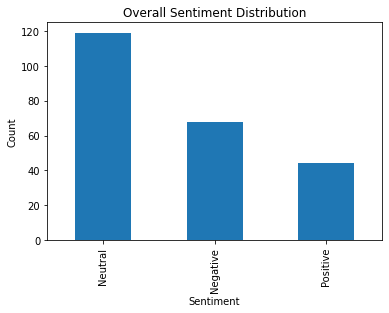

In [ ]:
df['sentiment'].value_counts().plot(kind='bar', xlabel='Sentiment',
                                    ylabel='Count', title='Overall Sentiment Distribution')

In [ ]:
# Filter tweets by sentiment and user followers
df.clean_tweet[(df.sentiment=='Negative') & (df.user_followers>np.mean(df.user_followers))]

0      EUR CHF at new year lows scope for a free fall to the 1 0505 2020 trough Commerzbank                                                                                                                                   
1      EUR CHF Scope for a nosedive to the 1 05 level Credit Suisse                                                                                                                                                           
9      EUR CHF to suffer further falls towards the 1 0620 1 0580 zone SocGen                                                                                                                                                  
13     EUR CHF Potential to plummet to the 1 05 level Credit Suisse                                                                                                                                                           
21     EUR CHF Major support down to 1 0623 to hold the initial test Commerzbank                            

In [ ]:

from datetime import datetime, timedelta, timezone

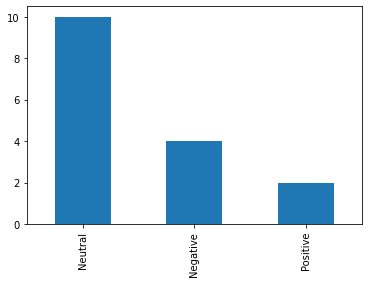

In [ ]:
# select last hour tweets 
df.sentiment[(df.created_at > (datetime.now() - timedelta(hours = 5)).replace(tzinfo=timezone.utc))].value_counts().plot(kind='bar')

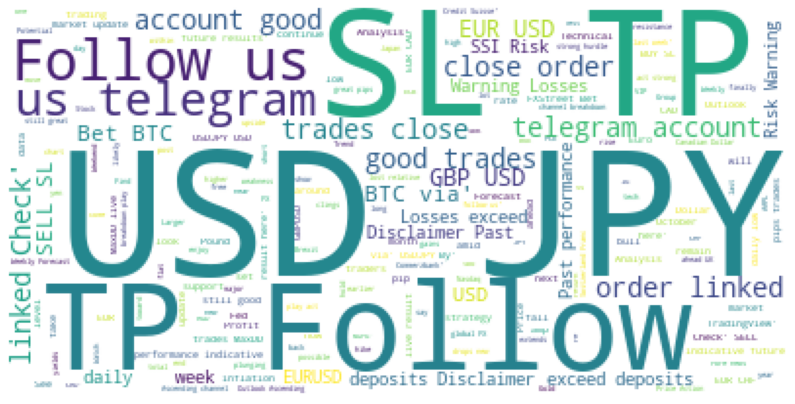

In [ ]:
from wordcloud import WordCloud, STOPWORDS

text = df.clean_tweet.values 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color ='white', stopwords = stopwords).generate(str(text))
plt.figure(figsize=(14,10))
colormap="hsv"
plt.imshow(wordcloud)

plt.axis("off")
plt.show()

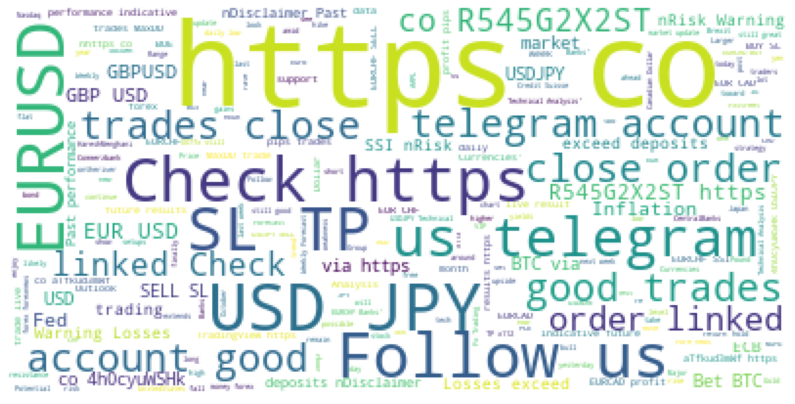

In [ ]:
text = df.tweet.values 

wordcloud = WordCloud(background_color ='white', stopwords = stopwords).generate(str(text))
plt.figure(figsize=(14,10))
colormap="hsv"
plt.imshow(wordcloud)

plt.axis("off")
plt.show()